## Notebook to track ADNI subjects with two visits

### Last ADNI download (July 2022)

### Derivative proc status 
- Based on `fmriprep_validator.py` and `fs_validator.py`

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

### Paths to list of subjects and images

In [2]:
project_dir = "/home/nikhil/projects/brain_changes/"
data_dir = f"{project_dir}/data/"
adni_dir = f"{data_dir}/adni/"

# ADNI paths
## ADNIMERGE
adnimerge_file = f"{adni_dir}/tabular/ADNIMERGE.csv"

## Image collections metadata (used for nii names and acq_data)
collections_dir = f"{adni_dir}downloads/collections/"
nii_paths_dir = f"{adni_dir}downloads/nii_paths/"

## fmriprep proc status dir
proc_status_dir = f"{adni_dir}adni123_bl_m24_July_2022/proc_status/"

## Freesurfer collated stats dir
FS_stats_dir = f"{adni_dir}adni123_bl_m24_July_2022/derivatives/freesurfer_agg/"

## exp setup dir 
exp_setup_dir = f"/home/nikhil/projects/brain_changes/data/exp_setup/adni/"


### Load ADNIMERGE

In [3]:
adnimerge_df = pd.read_csv(adnimerge_file)
print(f"ADNIMERGE len: {len(adnimerge_df)}")

visit_codes = adnimerge_df["VISCODE"].unique()
print(f"number of unique visit codes: {len(visit_codes)}")

ADNI1_subjects = adnimerge_df[adnimerge_df["ORIGPROT"]=="ADNI1"]["PTID"].unique()
ADNI2_subjects = adnimerge_df[adnimerge_df["ORIGPROT"]=="ADNI2"]["PTID"].unique()
ADNI3_subjects = adnimerge_df[adnimerge_df["ORIGPROT"]=="ADNI3"]["PTID"].unique()

print(f"number of ADNI1 subjects: {len(ADNI1_subjects)}, number of ADNI2 subjects: {len(ADNI2_subjects)}, number of ADNI3 subjects: {len(ADNI3_subjects)}")

# example subjects:
# sample_sub_id = "002_S_0295"
# adnimerge_df[adnimerge_df["PTID"]==sample_sub_id]

adnimerge_df.head()

ADNIMERGE len: 16014
number of unique visit codes: 35
number of ADNI1 subjects: 819, number of ADNI2 subjects: 790, number of ADNI3 subjects: 674


,RID,COLPROT,ORIGPROT,PTID,SITE,VISCODE,EXAMDATE,DX_bl,AGE,PTGENDER,...,PTAU_bl,FDG_bl,PIB_bl,AV45_bl,FBB_bl,Years_bl,Month_bl,Month,M,update_stamp
0,2,ADNI1,ADNI1,011_S_0002,11,bl,2005-09-08,CN,74.3,Male,...,NaN,1.25173,NaN,NaN,NaN,0.000000,0.00000,0,0,2022-06-22 16:41:44.0
1,3,ADNI1,ADNI1,011_S_0003,11,bl,2005-09-12,AD,81.3,Male,...,22.83,1.22163,NaN,NaN,NaN,0.000000,0.00000,0,0,2022-06-22 16:41:44.0
2,3,ADNI1,ADNI1,011_S_0003,11,m06,2006-03-13,AD,81.3,Male,...,22.83,1.22163,NaN,NaN,NaN,0.498289,5.96721,6,6,2022-06-22 16:41:44.0
3,3,ADNI1,ADNI1,011_S_0003,11,m12,2006-09-12,AD,81.3,Male,...,22.83,1.22163,NaN,NaN,NaN,0.999316,11.96720,12,12,2022-06-22 16:41:44.0
4,3,ADNI1,ADNI1,011_S_0003,11,m24,2007-09-12,AD,81.3,Male,...,22.83,1.22163,NaN,NaN,NaN,1.998630,23.93440,24,24,2022-06-22 16:41:44.0


### Generate available collection dictionary to search nii files
- These collections are downloaded at different times from LONI 

In [4]:
# Data download CSVs (from LONI collections)
# Vincent's download
adni12_long = f"{collections_dir}/ADNI123_logitudinal_collection_8_04_2021.csv"

# Nikhil's download
adni12_baseline = f"{collections_dir}/ADNI1-2_Baseline_MP-RAGE_5_08_2022.csv"
adni123_post_ohbm_1 = f"{collections_dir}/ADNI123_post_ohbm_1_7_15_2022.csv"
adni123_post_ohbm_2 = f"{collections_dir}/ADNI123_post_ohbm_2_7_15_2022.csv"

# Yasser's download
adni3_long = f"{collections_dir}/ADNI3_T1_10_20_2020.csv"

download_collections = {"adni12_long":adni12_long, "adni12_baseline":adni12_baseline, "adni3_long":adni3_long, 
                        "adni123_post_ohbm_1":adni123_post_ohbm_1,"adni123_post_ohbm_2":adni123_post_ohbm_2}

# nifti paths
nii_path_files = {
    "adni123_collated_paths": f"{nii_paths_dir}adni123_collated_nii_paths.txt"
}


### Count number of subjects for given visits

In [5]:
cohorts = ["ADNI1","ADNI2","ADNI3"]
visit_1 = "bl"
visit_2 = "m24"

PTID_bl = adnimerge_df[adnimerge_df["ORIGPROT"].isin(cohorts) & adnimerge_df["VISCODE"].isin([visit_1])]["PTID"].unique()
PTID_m24 = adnimerge_df[adnimerge_df["ORIGPROT"].isin(cohorts) & adnimerge_df["VISCODE"].isin([visit_2])]["PTID"].unique()

PTID_bl_and_m24 = set(PTID_bl) & set(PTID_m24)

print(f"n_subs, BL: {len(PTID_bl)}, m24: {len(PTID_m24)}, BL and m24: {len(PTID_bl_and_m24)}")

n_subs, BL: 2283, m24: 1479, BL and m24: 1479


### Image and subject ID dataframe

In [6]:
collection_df = pd.DataFrame()
for k,v in download_collections.items():
    print(f"Reading download collection: {k}")
    _df = pd.read_csv(v)
    _df = _df[_df["Type"]=="Original"]
    n_subjects = len(_df["Subject"].unique())
    n_scans = len(_df["Image Data ID"].unique())

    print(f"Number of unique subjects: {n_subjects}, images: {n_scans}")
    collection_df = collection_df.append(_df)

collection_df = collection_df.drop_duplicates(subset=["Subject","Image Data ID"], keep="last")

n_subjects = len(collection_df["Subject"].unique())
n_scans = len(collection_df["Image Data ID"].unique())
visits = np.sort(collection_df["Visit"].unique())

print('\nEntire available collections:')
print(f"Number of unique subjects: {n_subjects}, images: {n_scans} \nvisits: {visits}")

collection_df.head()

Reading download collection: adni12_long
Number of unique subjects: 1057, images: 3573
Reading download collection: adni12_baseline
Number of unique subjects: 780, images: 1240
Reading download collection: adni3_long
Number of unique subjects: 165, images: 650
Reading download collection: adni123_post_ohbm_1
Number of unique subjects: 786, images: 5059
Reading download collection: adni123_post_ohbm_2
Number of unique subjects: 615, images: 2763

Entire available collections:
Number of unique subjects: 1669, images: 8672 
visits: [  1   2   3   4   5   6   8  10  13  14  15  17  22  24  25  26  28  30
  32  34  36  50 101 102 103 104 105]


,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,I395985,130_S_4982,AD,F,59,28,MRI,MPRAGE,Original,10/25/2013,DCM,NaN
15,I355006,032_S_4823,EMCI,M,83,25,MRI,MPRAGE,Original,1/14/2013,DCM,8/04/2021
22,I399272,082_S_5014,EMCI,M,78,28,MRI,MPRAGE,Original,11/21/2013,DCM,NaN
24,I763197,141_S_2333,EMCI,M,70,30,MRI,MPRAGE,Original,4/29/2014,DCM,NaN
28,I116538,941_S_1295,MCI,M,78,5,MRI,MPRAGE,Original,8/19/2008,DCM,8/03/2021


### Count baseline and follow-up subjects from donwload collections
- These are based on csv generated from LONI download collection  
- According to Vincent, baseline visits: ADNI1=v2, ADNI2, ADNI3=v3
- Currently matching acq date from the nii image file name to the adnimerge dates to assign visit. 

In [7]:
# baseline_df = collection_df[collection_df["Visit"].isin([2,3])]
baseline_df = collection_df.copy()
baseline_subject_ids = baseline_df["Subject"].unique()
print(f"n_baseline_subjects: {len(baseline_subject_ids)}")
baseline_df.head()

n_baseline_subjects: 1669


,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,I395985,130_S_4982,AD,F,59,28,MRI,MPRAGE,Original,10/25/2013,DCM,NaN
15,I355006,032_S_4823,EMCI,M,83,25,MRI,MPRAGE,Original,1/14/2013,DCM,8/04/2021
22,I399272,082_S_5014,EMCI,M,78,28,MRI,MPRAGE,Original,11/21/2013,DCM,NaN
24,I763197,141_S_2333,EMCI,M,70,30,MRI,MPRAGE,Original,4/29/2014,DCM,NaN
28,I116538,941_S_1295,MCI,M,78,5,MRI,MPRAGE,Original,8/19/2008,DCM,8/03/2021


In [8]:
followup_df = collection_df.drop_duplicates(subset=["Subject","Acq Date"], keep="last")
 
scan_count_df = pd.DataFrame(followup_df["Subject"].value_counts())
scan_count_df.columns = ["n_scans"]

subject_ids_follow_up = scan_count_df[scan_count_df["n_scans"]>1]
n_follow_up_scans = len(subject_ids_follow_up)
print(f"number of subject with follow-up scans: {n_follow_up_scans}")

followup_df = followup_df[followup_df["Subject"].isin(baseline_subject_ids)]

followup_subject_ids = followup_df["Subject"].unique()
print(f"n_followup_subjects (with baseline scan): {len(followup_subject_ids)}")

followup_df.head()

number of subject with follow-up scans: 1447
n_followup_subjects (with baseline scan): 1669


,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,I395985,130_S_4982,AD,F,59,28,MRI,MPRAGE,Original,10/25/2013,DCM,NaN
15,I355006,032_S_4823,EMCI,M,83,25,MRI,MPRAGE,Original,1/14/2013,DCM,8/04/2021
22,I399272,082_S_5014,EMCI,M,78,28,MRI,MPRAGE,Original,11/21/2013,DCM,NaN
24,I763197,141_S_2333,EMCI,M,70,30,MRI,MPRAGE,Original,4/29/2014,DCM,NaN
28,I116538,941_S_1295,MCI,M,78,5,MRI,MPRAGE,Original,8/19/2008,DCM,8/03/2021


## Read all available nii paths

In [9]:
nii_paths = []
for k,v in nii_path_files.items():
    print(f"Reading nii path file: {k}")
    nii_paths += list(pd.read_csv(v,header=None)[0].values)

print(f"number of nii paths: {len(nii_paths)}")
nii_paths[:2]

Reading nii path file: adni123_collated_paths
number of nii paths: 10419


['./ADNI123_post_ohbm_3_5/ADNI/141_S_0915/MPRAGE_Repeat/2006-11-19_16_52_31.0/S22747/ADNI_141_S_0915_MR_MPRAGE_Repeat__br_raw_20061121113714882_138_S22747_I30232.nii',
 './ADNI123_post_ohbm_3_5/ADNI/021_S_0141/MP-RAGE_REPEAT/2007-02-22_15_10_22.0/S27047/ADNI_021_S_0141_MR_MP-RAGE_REPEAT_br_raw_20070223105841388_13_S27047_I41505.nii']

### Helper functions to parse filenames
- identifies acq_date and its closest match in ADNIMERGE
- drop duplicate scans for a given subject

In [10]:
def get_subject_info_from_path(p):
    """ Parses nii file name to grab ptid, iid, and acq_data
    """
    nii_file_name = p.rsplit("/",1)[1]
    ptid = nii_file_name.split("_")[1] + "_S_" + nii_file_name.split("_")[3]
    acq_date = p.rsplit("/",3)[1].split("_")[0]
    img_id = nii_file_name[::-1].split(".")[1].split("_")[0][::-1]

    return nii_file_name, ptid, acq_date, img_id

def get_closest_visit_code(subject_df, acq_date):
    """ Finds the closest acq date match with ADNIMERGE
    """
    date_diff_list = (pd.to_datetime(subject_df['EXAMDATE'].values, yearfirst=True, format="%Y/%m/%d") - 
                pd.to_datetime(acq_date, yearfirst=True, format="%Y/%m/%d"))

    closest_date_idx = np.argmin(np.abs(date_diff_list))
    diff_in_days = np.min(np.abs(date_diff_list)).days
    closest_date = subject_df['EXAMDATE'].values[closest_date_idx]

    visit_code = subject_df[subject_df["EXAMDATE"]==closest_date]['VISCODE'].values[0]

    return visit_code, diff_in_days


def filter_scans(nii_df, str_match, iid_criterion):
    """ Filters and selects single scan per timepoint based on nii file names and IIDs
    """
    n_ptids = len(nii_df["PTID"].unique())

    assert n_ptids == 1
    
    nii_df = nii_df[nii_df["nii_file_name"].str.contains(str_match)].sort_values(by=["PTID", "visit_code", "IID"])

    visits = nii_df["visit_code"].unique()

    # print(f"number of visits: {len(visits)}")

    filtered_nii_df = pd.DataFrame()
    n_scans = []
    for v, visit in enumerate(visits):
        df = nii_df[nii_df["visit_code"]==visit].copy()
        n_scans.append(len(df))

        if iid_criterion == "first":
            filtered_nii_df = filtered_nii_df.append(df.iloc[0])

        elif iid_criterion == "last":
            filtered_nii_df = filtered_nii_df.append(df.iloc[-1])


        else:
            print("Unknown iid selection criterion")


    filtered_nii_df["available_scans"] = n_scans
    return filtered_nii_df

### Search all available nii files for a given subject

In [11]:
nii_path_df = pd.DataFrame()
for p in nii_paths:
    nii_file_name, ptid, acq_date, img_id = get_subject_info_from_path(p)

    subject_df = adnimerge_df[(adnimerge_df["PTID"]==ptid)]

    try:    
        visit_code, diff_in_days = get_closest_visit_code(subject_df, acq_date)

        df = pd.DataFrame(columns=["PTID","IID","visit_code","acq_date","diff_in_days","nii_file_name","nii_path"])
        df.loc[0] = [ptid, img_id, visit_code, acq_date, diff_in_days, nii_file_name,p]
        nii_path_df = pd.concat([nii_path_df,df],axis=0)
        
    except:
        print(f"Error for path: {p}")
        continue

nii_path_df_bl_m24 = nii_path_df[nii_path_df["visit_code"].isin(["bl","m24"])]

print(f"\nnumber of nii paths for bl and m24: {len(nii_path_df_bl_m24)}")

nii_path_df_bl_m24.head()


number of nii paths for bl and m24: 3331


,PTID,IID,visit_code,acq_date,diff_in_days,nii_file_name,nii_path
0,141_S_0915,I30232,bl,2006-11-19,19,ADNI_141_S_0915_MR_MPRAGE_Repeat__br_raw_20061...,./ADNI123_post_ohbm_3_5/ADNI/141_S_0915/MPRAGE...
0,029_S_1073,I129688,m24,2008-12-08,3,ADNI_029_S_1073_MR_MP-RAGE_REPEAT_br_raw_20081...,./ADNI123_post_ohbm_3_5/ADNI/029_S_1073/MP-RAG...
0,131_S_0441,I14092,bl,2006-04-24,15,ADNI_131_S_0441_MR_MP-RAGE_REPEAT_br_raw_20060...,./ADNI123_post_ohbm_3_5/ADNI/131_S_0441/MP-RAG...
0,131_S_0441,I103963,m24,2008-04-24,0,ADNI_131_S_0441_MR_MP-RAGE_REPEAT_br_raw_20080...,./ADNI123_post_ohbm_3_5/ADNI/131_S_0441/MP-RAG...
0,136_S_0186,I95117,m24,2008-03-03,0,ADNI_136_S_0186_MR_MP-RAGE_REPEAT_br_raw_20080...,./ADNI123_post_ohbm_3_5/ADNI/136_S_0186/MP-RAG...


### Merge nii_df and adnimerge 

In [12]:
adni_nii_df = pd.merge(nii_path_df_bl_m24,adnimerge_df[["PTID"]],how="inner",on="PTID") #["ORIGPROT","AGE","DX_bl"]
adni_nii_df = adni_nii_df.drop_duplicates()
adni_nii_df = adni_nii_df[adni_nii_df["nii_file_name"].str.contains("RAGE")].sort_values(by=["PTID","visit_code"])

visit_count_df = adni_nii_df["PTID"].value_counts().reset_index().rename(columns={"index":"PTID","PTID":"count"})
visit_count_df[visit_count_df["count"]>1]

,PTID,count
0,100_S_0190,8
1,012_S_1009,8
2,133_S_1170,8
3,012_S_0689,8
4,131_S_0441,7
...,...,...
1152,141_S_0810,2
1153,073_S_4443,2
1154,036_S_4562,2
1155,114_S_0374,2


### Identify subjects with missing visit

In [13]:
str_match = "RAGE"
iid_criterion = "last"

filtered_nii_df = pd.DataFrame()

for ptid in adni_nii_df["PTID"].unique():
    subject_nii_df = adni_nii_df[adni_nii_df["PTID"]==ptid]
    filtered_subject_nii_df = filter_scans(subject_nii_df, str_match, iid_criterion)
    filtered_nii_df = filtered_nii_df.append(filtered_subject_nii_df)

print(f"filtered_df shape: {len(filtered_nii_df)}")

filtered_nii_df[filtered_nii_df["available_scans"]>1].head()

filtered_df shape: 2485


,IID,PTID,acq_date,diff_in_days,nii_file_name,nii_path,visit_code,available_scans
1434,I114210,002_S_0295,2008-07-23,12.0,ADNI_002_S_0295_MR_MP-RAGE__br_raw_20080723212...,./ADNI123_post_ohbm_2_4/ADNI/002_S_0295/MP-RAG...,m24,2
19533,I115006,002_S_0413,2008-07-31,0.0,ADNI_002_S_0413_MR_MPRAGE_br_raw_2008073122391...,./ADNI123_post_ohbm_1_3/ADNI/002_S_0413/MPRAGE...,m24,2
9229,I116582,002_S_0559,2008-08-15,4.0,ADNI_002_S_0559_MR_MPRAGE_br_raw_2008082122391...,./ADNI123_post_ohbm_1_3/ADNI/002_S_0559/MPRAGE...,m24,2
3052,I16391,002_S_0619,2006-06-01,19.0,ADNI_002_S_0619_MR_MP-RAGE_REPEAT_br_raw_20060...,./ADNI123_post_ohbm_3_4/ADNI/002_S_0619/MP-RAG...,bl,2
3047,I116120,002_S_0619,2008-08-13,6.0,ADNI_002_S_0619_MR_MP-RAGE_REPEAT_br_raw_20080...,./ADNI123_post_ohbm_3_1/ADNI/002_S_0619/MP-RAG...,m24,2


In [14]:
visit_count_df = pd.DataFrame(filtered_nii_df["PTID"].value_counts()).reset_index()
visit_count_df = visit_count_df.rename(columns={"index":"PTID","PTID":"count"})

single_visit_subjects = visit_count_df[visit_count_df["count"]==1]["PTID"]
multiple_visit_subjects = visit_count_df[visit_count_df["count"] == 2]["PTID"]
multiple_visit_df = filtered_nii_df[filtered_nii_df["PTID"].isin(multiple_visit_subjects)]

print(f"number of single visit subjects: {len(single_visit_subjects)}\n"
 f"number of multiple visit subjects: {len(multiple_visit_subjects)}")

number of single visit subjects: 281
number of multiple visit subjects: 1102


### OHMB subjects

In [15]:
ohbm_subject_ids = pd.read_csv(f"{adni_dir}/subject_ids/adni_long_ohbm_subject_ids.txt",header=None)
ohbm_ptids = ohbm_subject_ids[0].str[4:7] + "_S_" + ohbm_subject_ids[0].str[8:]

ohbm_only_subs = set(ohbm_ptids) - set(multiple_visit_subjects)
post_ohbm_subs = set(multiple_visit_subjects) - set(ohbm_ptids)

print(f"number of ohbm subs not in the new downloads: {len(ohbm_only_subs)}")
print(f"number of post ohbm subs from the new downloads: {len(post_ohbm_subs)}")

fmriprep_subs = [f"ADNI{s[:3]}S{s[-4:]}" for s in list(post_ohbm_subs)]

number of ohbm subs not in the new downloads: 4
number of post ohbm subs from the new downloads: 839


### Generate participants.tsv
- BIDS Dir: /home/nikhil/projects/brain_changes/data/adni/bids
- This is a list of subject to be processed (depending on proc fails, not all of them will be used in the exp_setup)

In [16]:
save_csv = False 

multiple_visit_subjects = set(multiple_visit_subjects) | set(ohbm_ptids)
print(f"Total number of subjects with two {visit_1} and {visit_2} visits: {len(multiple_visit_subjects)}")
participant_df = adnimerge_df[(adnimerge_df["PTID"].isin(multiple_visit_subjects)) & (adnimerge_df["VISCODE"]=="bl")].copy()
participant_cols_dict = {"PTID":"participant_id",
                        "AGE":"age",
                        "PTGENDER":"sex",
                        "DX_bl":"group",
                        "COLPROT":"COLPROT",
                        "ORIGPROT":"ORIGPROT"}

participant_df = participant_df[participant_cols_dict.keys()].rename(columns=participant_cols_dict)

# rename participants_id in BIDS format
participant_df["participant_id"] = [f"sub-ADNI{s[:3]}S{s[-4:]}" for s in list(participant_df["participant_id"])] 

if save_csv:
    # repo metadata
    participant_df.to_csv(f'{adni_dir}subject_ids/participants.csv',index=None)
    # BIDS dir
    participant_df.to_csv(f'{adni_dir}bids/participants.tsv', index=None, sep="\t") 

participant_df.head()

Total number of subjects with two bl and m24 visits: 1106


,participant_id,age,sex,group,COLPROT,ORIGPROT
1,sub-ADNI011S0003,81.3,Male,AD,ADNI1,ADNI1
10,sub-ADNI011S0005,73.7,Male,CN,ADNI1,ADNI1
15,sub-ADNI100S0006,80.4,Female,LMCI,ADNI1,ADNI1
20,sub-ADNI022S0007,75.4,Male,AD,ADNI1,ADNI1
22,sub-ADNI011S0010,73.9,Female,AD,ADNI1,ADNI1


## Plots

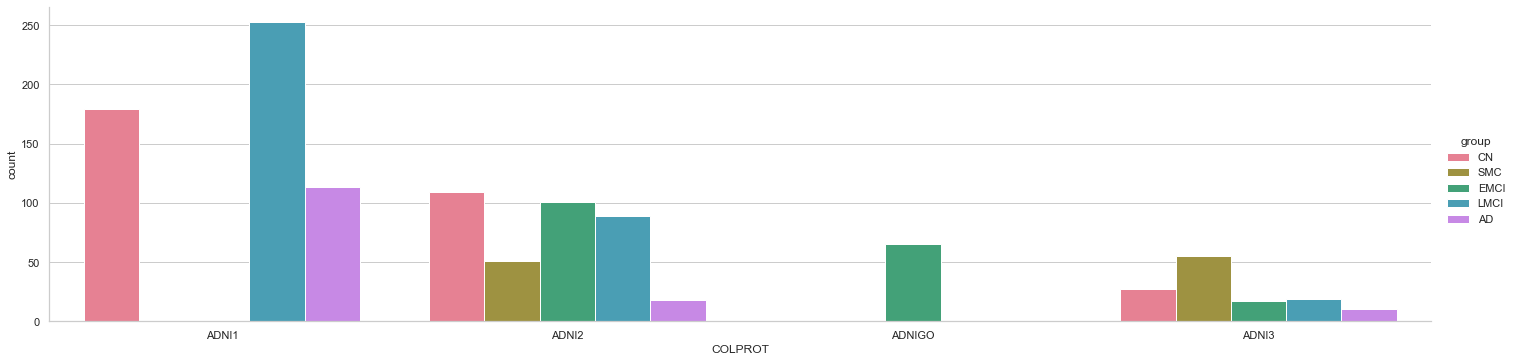

In [17]:
plot_df = participant_df.copy()
palette = 'husl'
group_order = ["CN","SMC","EMCI","LMCI","AD"]
sns.set(font_scale=1)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x="COLPROT", hue="group", hue_order=group_order, kind='count',
    aspect=4, height=5, palette = palette, data=plot_df)

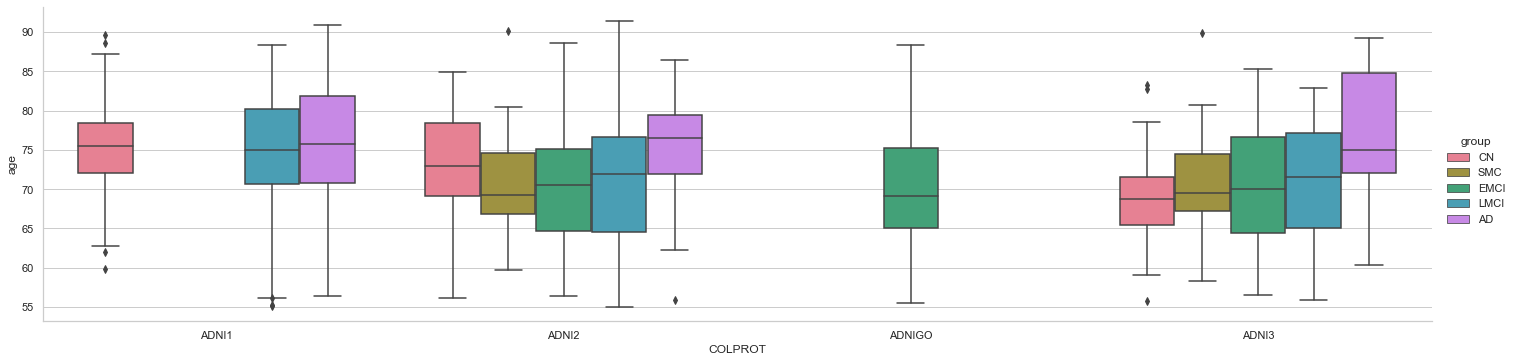

In [18]:
plot_df = participant_df.copy()
palette = 'husl'
group_order = ["CN","SMC","EMCI","LMCI","AD"]
sns.set(font_scale=1)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="age", x="COLPROT", hue="group", hue_order=group_order, kind='box',
    aspect=4, height=5, palette = palette, data=plot_df)

## Proc pipeline status

### Check fmriprep proc status

In [19]:
ses_list = ["ses-bl","ses-m24"]
fmriprep_ids_dict = {}
modality = "anat"

for ses in ses_list:
    fmristatus_csv = f"{proc_status_dir}/{ses}/fmriprep_status.csv"

    fmristatus_df = pd.read_csv(fmristatus_csv)

    fmriprep_ids_dict[ses] = fmristatus_df[fmristatus_df[f"{modality}-MNI152NLin6Sym_res-1"]=="Pass"]["participant_id"].values

    n_MNI152NLin2009cSym = len(fmristatus_df[fmristatus_df[f"{modality}-MNI152NLin2009cSym_res-1"]=="Pass"])
    n_MNI152NLin6Sym = len(fmristatus_df[fmristatus_df[f"{modality}-MNI152NLin6Sym_res-1"]=="Pass"])
    n_MNI152Lin = len(fmristatus_df[fmristatus_df[f"{modality}-MNI152Lin_res-1"]=="Pass"])
    n_fsl_MNI152NLin6Sym = len(fmristatus_df[fmristatus_df["fsl-MNI152NLin6Sym_res-1"]=="Pass"])

    print(f"Session: {ses}")
    print(f"n_MNI152NLin2009cSym: {n_MNI152NLin2009cSym}, n_MNI152NLin6Sym: {n_MNI152NLin6Sym} "
    f"n_MNI152Lin: {n_MNI152Lin}, n_fsl_MNI152NLin6Sym:{n_fsl_MNI152NLin6Sym}")
    print("")

fmriprep_success_ids = set(fmriprep_ids_dict["ses-bl"]) & set(fmriprep_ids_dict["ses-m24"])
print(f"n_fmriprep_success_ids: {len(fmriprep_success_ids)}")
fmristatus_df.head()

Session: ses-bl
n_MNI152NLin2009cSym: 1106, n_MNI152NLin6Sym: 1103 n_MNI152Lin: 1106, n_fsl_MNI152NLin6Sym:1104

Session: ses-m24
n_MNI152NLin2009cSym: 1104, n_MNI152NLin6Sym: 1105 n_MNI152Lin: 1102, n_fsl_MNI152NLin6Sym:1099

n_fmriprep_success_ids: 1102


,Unnamed: 0,participant_id,anat-fmriprep_complete,anat-MNI152NLin2009cSym_res-1,anat-MNI152NLin6Sym_res-1,anat-MNI152Lin_res-1,fsl-MNI152NLin6Sym_res-1,fmriprep_complete
0,0,sub-ADNI128S4571,True,Pass,Pass,Pass,Pass,True
1,1,sub-ADNI041S4200,True,Pass,Pass,Pass,Pass,True
2,2,sub-ADNI024S0985,True,Pass,Pass,Pass,Pass,True
3,3,sub-ADNI072S4613,True,Pass,Pass,Pass,Pass,True
4,4,sub-ADNI099S0533,True,Pass,Pass,Pass,Pass,True


### Check Freesurfer stats status

In [20]:
BL_CT_file = f"{FS_stats_dir}/ses-bl/DKTatlas_average_thickness.csv"
BL_ASEG_file = f"{FS_stats_dir}/ses-bl/aseg_subcortical_volumes.csv"

FU_CT_file = f"{FS_stats_dir}/ses-m24/DKTatlas_average_thickness.csv"
FU_ASEG_file = f"{FS_stats_dir}/ses-m24/aseg_subcortical_volumes.csv"


BL_CT_ids = pd.read_csv(BL_CT_file)["subject_id"].values
BL_ASEG_ids = pd.read_csv(BL_ASEG_file)["subject_id"].values
FU_CT_ids = pd.read_csv(FU_CT_file)["subject_id"].values
FU_ASEG_ids = pd.read_csv(FU_ASEG_file)["subject_id"].values
FS_success_ids = set(BL_CT_ids) & set(FU_CT_ids)

print(f"n_BL_CT: {len(BL_CT_ids)}, n_BL_ASEG: {len(BL_ASEG_ids)}")
print(f"n_FU_CT: {len(FU_CT_ids)}, n_FU_ASEG: {len(FU_ASEG_ids)}")
print(f"n_freesurfer_success_ids: {len(FS_success_ids)}")


n_BL_CT: 1211, n_BL_ASEG: 1211
n_FU_CT: 1102, n_FU_ASEG: 1102
n_freesurfer_success_ids: 1093


### ADNI exp_setup manifest 
- List all the subjects you want to drop here
- Save demographics and FreeSurfer data

In [25]:
participant_df = pd.read_csv(f'{adni_dir}subject_ids/participants.csv')

proc_success_ids = list(fmriprep_success_ids & FS_success_ids)
print(f"n proc_success ids: {len(proc_success_ids)}")

## Some outlier that need to be looked at (most likely proc failures)
drop_subjects = ["sub-ADNI082S4244"] #sub-ADNI082S4244 --> super low inter-visit correlation

for ds in drop_subjects:
    proc_success_ids.remove(ds)

print(f"n proc_success ids (after outlier drop): {len(proc_success_ids)}")

n proc_success ids: 1090
n proc_success ids (after outlier drop): 1089


In [34]:
save_exp_data = False

demographics_df = participant_df[participant_df["participant_id"].isin(proc_success_ids)].copy()

BL_CT_df = pd.read_csv(BL_CT_file)
FU_CT_df = pd.read_csv(FU_CT_file)

DKT_df = BL_CT_df.append(FU_CT_df)

exp_DKT_df = DKT_df[DKT_df["subject_id"].isin(proc_success_ids)]
print(f"demographics_df shape: {len(demographics_df)}, exp_DKT_df shape: {exp_DKT_df.shape}")

if save_exp_data:
    demographics_df.to_csv(f"{exp_setup_dir}/adni_exp_data_demographics.csv",index=None)
    exp_DKT_df.to_csv(f"{exp_setup_dir}/adni_exp_data_DKT.csv",index=None)

demographics_df shape: 1089, exp_DKT_df shape: (2178, 64)
